<a href="https://colab.research.google.com/github/vicmcl/deeplearwing/blob/main/deeplearwing/notebook/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Imports**

In [14]:
%reload_ext autoreload
%autoreload 2

In [50]:
from pathlib import Path
import os
import glob
import warnings

warnings.filterwarnings("ignore")

In [16]:
# mount Drive
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive')
DRIVE_PATH = Path("/content/drive/MyDrive/")
ML_PATH = DRIVE_PATH / "Projects" / "deeplearwing"

Mounted at /content/drive


In [17]:
# Clone GitHub repository
!git clone https://github.com/vicmcl/deeplearwing.git

Cloning into 'deeplearwing'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 275 (delta 110), reused 132 (delta 63), pack-reused 50
Receiving objects: 100% (275/275), 31.06 MiB | 30.49 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [18]:
# Set path to dataset
DATASET = "victorienmichel/deeplearwing"
CONTENT_PATH = Path('/content')
PROJECT_PATH = CONTENT_PATH / 'deeplearwing'
DATA_PATH = PROJECT_PATH / 'data'
ZIP_FILE = DATASET.split('/')[-1].lower() + '.zip'

In [19]:
# Pull repository
!cd {PROJECT_PATH} && git pull origin main

# Copy src file to content folder
!cp -r {PROJECT_PATH / 'deeplearwing' / 'src'} {CONTENT_PATH}

From https://github.com/vicmcl/deeplearwing
 * branch            main       -> FETCH_HEAD
Already up to date.


In [20]:
# Create a data folder if it does not exist
if not os.path.exists(DATA_PATH):
    print(f'Creating {DATA_PATH}')
    os.makedirs(DATA_PATH)

# Download the dataset archive and extract it
if not glob.glob(str(DATA_PATH / '*.csv')):

    if not os.path.exists(PROJECT_PATH / ZIP_FILE):
        !kaggle datasets download -d {DATASET} -p {DATA_PATH}

    !unzip {DATA_PATH / ZIP_FILE} -d {DATA_PATH}
    !rm {DATA_PATH / ZIP_FILE}

Creating /content/deeplearwing/data
Dataset URL: https://www.kaggle.com/datasets/victorienmichel/deeplearwing
License(s): MIT
 27% 5.00M/18.3M [00:00<00:00, 51.7MB/s]
100% 18.3M/18.3M [00:00<00:00, 102MB/s] 
Archive:  /content/deeplearwing/data/deeplearwing.zip
  inflating: /content/deeplearwing/data/DeepLearWing.csv  


In [21]:
!pip install -q aerosandbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 36.1 MB/s eta 0:00:00


## **Tabular Data Processing**

In [157]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from src.features import string_to_floats
from src.plot import airfoil_to_image
from src.curvature_heatmap import compute_curvature
from src.checkpoint import checkpoint

### **Load CSV**

In [23]:
# Read CSV to Dataframe
df_csv = pd.read_csv(DATA_PATH / 'DeepLearWing.csv')
df_csv.head()

,name,angle,reynolds,x_coords,y_coords,cd,cl,cm
0,2032c,-8.75,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09761,-0.1581,-0.0262
1,2032c,-8.50,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09468,-0.1536,-0.0262
2,2032c,-8.25,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.10671,-0.2407,-0.0219
3,2032c,-8.00,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.10247,-0.2303,-0.0213
4,2032c,-7.75,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09947,-0.2229,-0.0215


### **Target distribution**

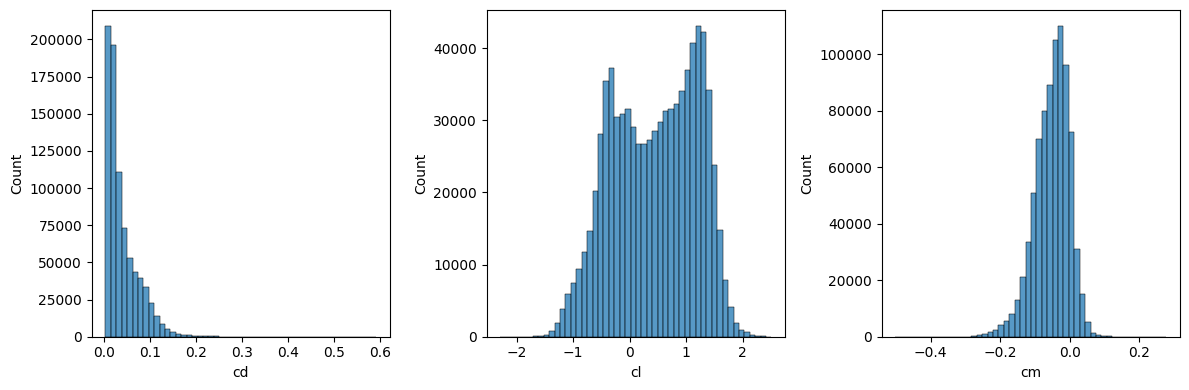

In [165]:
fig = plt.figure(figsize=(12, 4))

fig.add_subplot(1, 3, 1)
sns.histplot(df_csv['cd'], bins=50)

fig.add_subplot(1, 3, 2)
sns.histplot(df_csv['cl'], bins=50)

fig.add_subplot(1, 3, 3)
sns.histplot(df_csv['cm'], bins=50)

plt.tight_layout()

### **Sample 10 000 airfoils**

In [ ]:
# Sample 10 000 simulations results
n_samples = 10_000
df = df_csv.sample(n = n_samples, random_state = 42).copy()

### **Normalize values**

In [133]:
# Implement MinMaxScaler
mms_params = MinMaxScaler()
mms_target = MinMaxScaler()

df.loc[:, ['angle', 'reynolds']] = mms_params.fit_transform(df[['angle', 'reynolds']])

targets = ['cd', 'cl', 'cm']
df.loc[:, targets] = mms_target.fit_transform(df[targets])
df['target'] = df.apply(lambda row: [row[t] for t in targets], axis = 1)

df.loc[:, ['x_coords', 'y_coords']] = df[['x_coords', 'y_coords']].applymap(string_to_floats)

df = df.drop(columns = targets)

In [134]:
with open(ML_PATH / 'scaler_params.pkl', 'wb') as f:
    pickle.dump(mms_params, f)

with open(ML_PATH / 'scaler_target.pkl', 'wb') as f:
    pickle.dump(mms_target, f)

In [25]:
df.head()

,name,angle,reynolds,x_coords,y_coords,target
51063,fx84w127,0.823899,0.157895,"[1.0, 0.99893, 0.99572, 0.99039, 0.98296, 0.97...","[0.0, 0.00011, 0.0005, 0.0012, 0.0023, 0.00385...","[0.16410609714088875, 0.760406247595599, 0.437..."
802509,s8052,0.308176,0.052632,"[1.0, 0.99803, 0.99231, 0.98301, 0.97022, 0.95...","[0.0, 0.00018, 0.00079, 0.00181, 0.0033, 0.005...","[0.16927316569066483, 0.28383473109179047, 0.4..."
419227,goe505,0.301887,0.000000,"[1.0, 0.94959, 0.89918, 0.7985, 0.69791, 0.597...","[0.0, 0.01784, 0.03568, 0.06537, 0.09105, 0.10...","[0.4231140199793318, 0.34741350568079815, 0.46..."
132195,npl9660,0.735849,0.157895,"[1.0, 0.997614, 0.990418, 0.9785, 0.961985, 0....","[0.0013, 0.001763, 0.002031, 0.002194, 0.00332...","[0.07240785394419566, 0.7069067220640661, 0.49..."
542560,fx78k161,0.213836,0.473684,"[1.0, 0.99893, 0.99572, 0.99039, 0.98296, 0.97...","[0.0, 0.00103, 0.00172, 0.00262, 0.00365, 0.00...","[0.09951774026868758, 0.2525967530968685, 0.35..."


## **Image preprocessing**

In [26]:
import concurrent
from cv2 import GaussianBlur

In [27]:
w = 300
h = 100
blur = 5

In [28]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures_shape = [executor.submit(airfoil_to_image, row['x_coords'], row['y_coords'], w, h) for _, row in df.iterrows()]
    results_shape = [future.result() for future in futures_shape]

In [103]:
df['shape'] = [GaussianBlur(x, (blur, blur), 0) for x in results_shape]

### **Airfoil sample images**

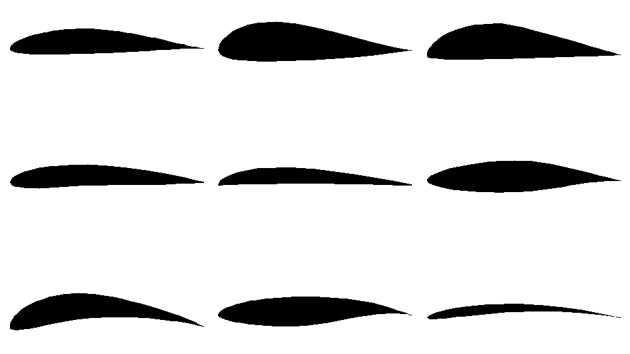

In [108]:
# Plot a set of different airfoils
fig = plt.figure()
for i, airfoil in enumerate(results_shape[0:81:9]):
    fig.add_subplot(3, 3, i + 1)
    plt.imshow(airfoil[::-1], cmap = 'gray')
    plt.axis('off')
plt.tight_layout()

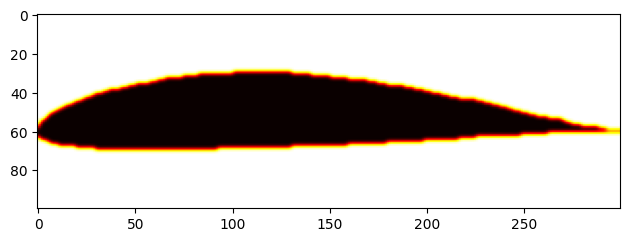

In [104]:
# Plot airfoil with blurred edges
plt.imshow(df['shape'].iloc[0][::-1], cmap = 'hot')
plt.tight_layout()

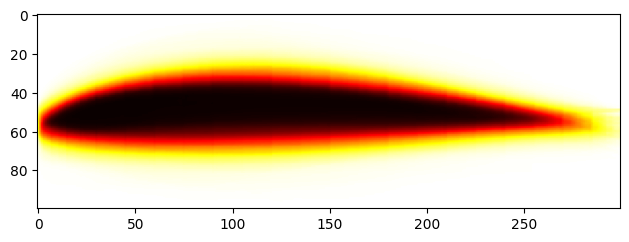

In [45]:
# Plot average airfoil
avg_airfoil = np.mean(results_shape, axis = 0)
plt.imshow(avg_airfoil[::-1], cmap='hot')
plt.tight_layout()

## **Train test split**

### **Split parameters**

In [33]:
# Combine angle and Reynolds number in a single column
df['params'] = [x for x in np.column_stack((df['angle'], df['reynolds']))]

# Train test split
features = ['params', 'shape']

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df['target'],
    test_size = 0.2,
    random_state = 42,
    shuffle = True
)

In [34]:
# Convert images to numpy arrays
images_train = np.expand_dims(np.array([x for x in X_train['shape']], dtype='float32'), axis = -1)
images_test = np.expand_dims(np.array([x for x in X_test['shape']], dtype='float32'), axis = -1)

# Convert params to numpy arrays
params_train = np.array([x for x in X_train['params']], dtype='float32')
params_test = np.array([x for x in X_test['params']], dtype='float32')

# Convert target to numpy arrays
y_train = np.array([x for x in y_train])
y_test = np.array([x for x in y_test])

In [35]:
# Check shapes
images_train.shape, images_test.shape, params_train.shape, params_test.shape, y_train.shape, y_test.shape

((8000, 100, 300, 1),
 (2000, 100, 300, 1),
 (8000, 2),
 (2000, 2),
 (8000, 3),
 (2000, 3))

In [36]:
# Save images, parameters and targets
with open(ML_PATH / 'images_train_shape.pkl', 'wb') as f:
    pickle.dump(images_train, f)

with open(ML_PATH / 'images_test_shape.pkl', 'wb') as f:
    pickle.dump(images_test, f)

with open(ML_PATH / 'params_train.pkl', 'wb') as f:
    pickle.dump(params_train, f)

with open(ML_PATH / 'params_test.pkl', 'wb') as f:
    pickle.dump(params_test, f)

with open(ML_PATH / 'y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

with open(ML_PATH / 'y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

### **Normalized target values in train set**

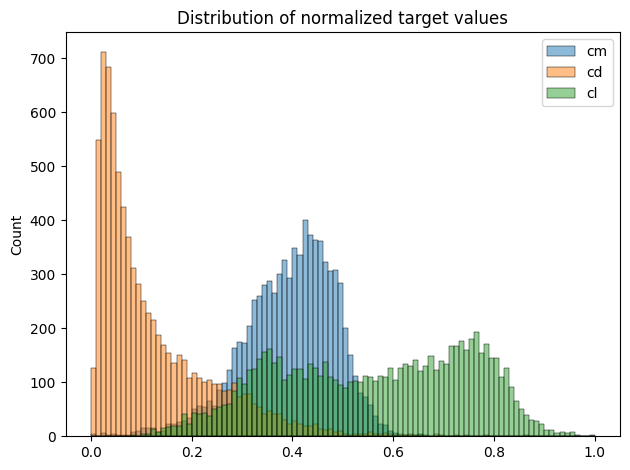

In [38]:
# plot normalized target values
sns.histplot(y_train[:, 2], label = 'cm', bins=100, alpha=0.5)
sns.histplot(y_train[:, 0], label = 'cd', bins=100, alpha=0.5)
sns.histplot(y_train[:, 1], label = 'cl', bins=100, alpha=0.5)
plt.legend()
plt.title('Distribution of normalized target values')
plt.tight_layout()

## **Model Training**

In [48]:
# Install Keras Tuner
pip install -q keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [9]:
import keras_tuner as kt

from tqdm import tqdm

from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    Concatenate,
)

In [ ]:
# Define the model architecture with all possible hyperparameters values
def build_model(hp, channels):

    normalization_conv = hp.Choice("Normalization_conv", ["yes", "no"])
    normalization_dense = hp.Choice("Normalization_dense", ["yes", "no"])

    dropout_conv = hp.Choice("dropout_conv", ["yes", "no"])
    dropout_dense = hp.Choice("dropout_dense", ["yes", "no"])

    rate_dropout_conv = hp.Float(
        "rate_dropout_conv", 0.1, 0.3, step = 0.1, default = 0.3
    )
    rate_dropout_dense = hp.Float(
        "rate_dropout_dense", 0.1, 0.3, step = 0.1, default = 0.3
    )

    # CNN branch
    cnn_input = Input(shape=(h, w, channels))
    x = cnn_input

    for i in range(hp.Int("conv_layers", 2, 4)):
        x = Conv2D(
            filters=hp.Int(
                "filters_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            kernel_size=hp.Int("kernel_size_" + str(i), 2, 4, step = 1),
            activation="relu",
            padding="same"
        )(x)

        x = MaxPooling2D()(x)

        if dropout_conv == "yes":
            x = Dropout(rate = rate_dropout_conv)(x)

        if normalization_conv == "yes":
            x = BatchNormalization()(x)

    cnn_output = Flatten()(x)

    # ANN branch
    ann_input = Input(shape=(2,))
    y = ann_input

    for i in range(hp.Int("dense_layers", 2, 4)):
        ann_output = Dense(
            units = hp.Int(
                "ann_neurons_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            activation = "relu",
        )(y)

    # Combine the outputs
    combined_inputs = Concatenate()([cnn_output, ann_output])

    for i in range(hp.Int("combined_dense_layers", 2, 4)):
        combined_output = Dense(
            units = hp.Int(
                "combined_neurons_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            activation = "relu",
        )(combined_inputs)

        if dropout_dense == "yes":
            x = Dropout(rate=rate_dropout_dense)(x)

        if normalization_dense == "yes":
            x = BatchNormalization()(x)

    combined_output = Dense(units=3)(combined_output)

    # Create the model
    combined_model = Model(
        inputs = [cnn_input, ann_input],
        outputs = combined_output,
        name = "Combined_model"
    )


    # Compile the model
    combined_model.compile(
        loss="mse",
        optimizer=Adam(learning_rate=0.0005),
        metrics=['mae']
    )

    return combined_model

In [ ]:
# Implement a Hyperband tuner to find the best model
tuner = kt.Hyperband(
    hypermodel = lambda hp: build_model(hp, channels=1),
    objective = "val_loss",
    max_epochs = 10,
    hyperband_iterations = 2,
    directory = PROJECT_PATH,
    project_name = "tuner",
    overwrite = True
)

# Search for the best model
tuner.search(
    [images_train, params_train],
    y_train,
    epochs = 10,
    batch_size = 32,
    shuffle = True,
    validation_split = 0.2,
)

# Save the best model
best_model = tuner.get_best_models()[0]
best_model.summary()
best_model.save(ML_PATH / "best_model_shape.keras")

Trial 60 Complete [00h 02m 12s]
val_loss: 0.01835777796804905

Best val_loss So Far: 0.003242496633902192
Total elapsed time: 00h 57m 55s
Model: "Combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 300, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 300, 128)        640       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 50, 150, 128)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                              

In [52]:
# Load and compile the best model
best_model = load_model(ML_PATH / "best_model_shape.keras", compile=False)
best_model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.0005),
    metrics=['mae']
)

In [53]:
# Load weights if they exist
if os.path.exists(ML_PATH / "weights_model_shape.h5"):
    best_model.load_weights(ML_PATH / "weights_model_shape.h5")
    print("Weights loaded.")
else:
    print("Weights not found.")

Weights not found.


In [54]:
# Retrain the best model found by the tuner until the early stopping criterion is met
history = best_model.fit(
    [images_train, params_train],
    y_train,
    epochs = 100,
    batch_size = 32,
    callbacks=checkpoint(ML_PATH / f"weights_model_shape.h5", patience=3),
    validation_split = 0.2,
    shuffle = True,
    verbose = 1,
)

Epoch 1/100
200/200 [==============================] - 23s 75ms/step - loss: 0.0027 - mae: 0.0375 - val_loss: 0.0030 - val_mae: 0.0376
Epoch 2/100
200/200 [==============================] - 14s 72ms/step - loss: 0.0025 - mae: 0.0360 - val_loss: 0.0031 - val_mae: 0.0377
Epoch 3/100
200/200 [==============================] - 14s 72ms/step - loss: 0.0024 - mae: 0.0354 - val_loss: 0.0031 - val_mae: 0.0377
Epoch 4/100
200/200 [==============================] - 15s 73ms/step - loss: 0.0023 - mae: 0.0344 - val_loss: 0.0030 - val_mae: 0.0360
Epoch 5/100
200/200 [==============================] - 15s 73ms/step - loss: 0.0021 - mae: 0.0331 - val_loss: 0.0027 - val_mae: 0.0348
Epoch 6/100
200/200 [==============================] - 15s 73ms/step - loss: 0.0020 - mae: 0.0321 - val_loss: 0.0027 - val_mae: 0.0340
Epoch 7/100
200/200 [==============================] - 14s 71ms/step - loss: 0.0019 - mae: 0.0309 - val_loss: 0.0027 - val_mae: 0.0339
Epoch 8/100
200/200 [==============================] - 

In [58]:
# Evaluate the model on the test set
evaluation = best_model.evaluate([images_test, params_test], y_test, verbose=0)
print("Test MSE:", evaluation[0])
print("Test MAE:", evaluation[1])

Test MSE: 0.0024250755086541176
Test MAE: 0.03429581969976425


### **Curvature Heatmap**

In [109]:
# Compute curvature of airfoils
curvatures = [compute_curvature(img) for img in tqdm(df['shape'])]

100%|██████████| 10000/10000 [01:58<00:00, 84.53it/s]


In [86]:
df['curvature'] = curvatures

In [62]:
# Combine shape and curvature in 2 channels for each image
# Process images by batches to avoid memory issues
def image_generator(df, batch_size=32):
    num_samples = len(df)
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_df = df.iloc[start:end]

        combined_images = []
        indices = []

        for idx, row in batch_df.iterrows():
            channel1 = np.array(row['shape'], dtype=np.float32)
            channel2 = np.array(row['curvature'], dtype=np.float32)
            combined_image = np.stack([channel1, channel2], axis=-1)
            combined_images.append(combined_image)
            indices.append(idx)

        yield pd.DataFrame({'combined_image': combined_images}, index=indices)

In [63]:
images_2_channels = pd.DataFrame()
for batch in image_generator(df):
    images_2_channels = pd.concat([images_2_channels, batch])

In [64]:
df = pd.concat([df, images_2_channels], axis=1)

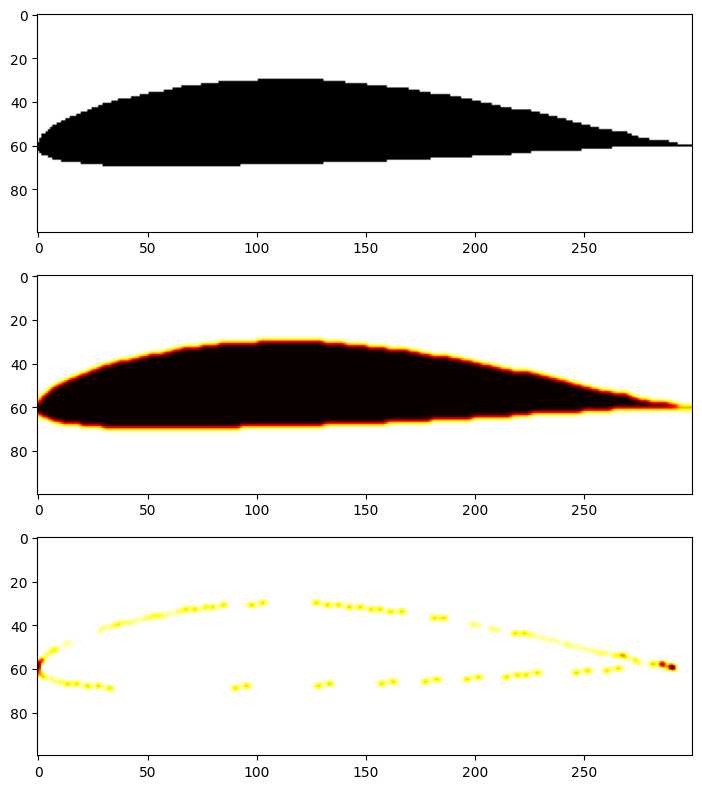

In [121]:
# Show the processing steps of an airfoil
n = 0
fig = plt.figure(figsize=(8, 8))

fig.add_subplot(3, 1, 1)
plt.imshow(results_shape[n][::-1], cmap = 'gray')

fig.add_subplot(3, 1, 2)
plt.imshow(df['shape'].iloc[n][::-1], cmap = 'hot')

fig.add_subplot(3, 1, 3)
plt.imshow(curvatures[n][::-1], cmap = 'hot_r')

plt.tight_layout()

In [123]:
# Train test split
features = ['combined_image', 'params']

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df['target'],
    test_size = 0.2,
    random_state = 42,
    shuffle = True
)

In [124]:
# Convert images to numpy arrays
images_train = np.array([x for x in X_train['combined_image']], dtype='float32')
images_test = np.array([x for x in X_test['combined_image']], dtype='float32')

# Convert parameters to numpy arrays
params_train = np.array([x for x in X_train['params']], dtype='float32')
params_test = np.array([x for x in X_test['params']], dtype='float32')

# Convert target values to numpy arrays
y_train = np.array([x for x in y_train])
y_test = np.array([x for x in y_test])

In [125]:
# Check shapes
images_train.shape, images_test.shape, params_train.shape, params_test.shape, y_train.shape, y_test.shape

((8000, 100, 300, 2),
 (2000, 100, 300, 2),
 (8000, 2),
 (2000, 2),
 (8000, 3),
 (2000, 3))

In [126]:
# Save the images with curvature heatmap
with open(ML_PATH / 'images_train_curvature.pkl', 'wb') as f:
    pickle.dump(images_train, f)

with open(ML_PATH / 'images_test_curvature.pkl', 'wb') as f:
    pickle.dump(images_test, f)

In [ ]:
# Implement a Hyperband tuner to find the best model
tuner = kt.Hyperband(
    hypermodel = lambda hp: build_model(hp, channels=2),
    objective = "val_loss",
    max_epochs = 10,
    hyperband_iterations = 2,
    directory = PROJECT_PATH,
    project_name = "tuner",
    overwrite = True
)

# Search for the best model
tuner.search(
    [images_train, params_train],
    y_train,
    epochs = 10,
    batch_size = 32,
    shuffle = True,
    validation_split = 0.2,
)

# Save the best model
best_model = tuner.get_best_models()[0]
best_model.summary()
best_model.save(ML_PATH / "best_model_curvature.keras")

Trial 60 Complete [00h 02m 02s]
val_loss: 0.0035377047024667263

Best val_loss So Far: 0.003119562054052949
Total elapsed time: 01h 00m 01s
Model: "Combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 300, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 300, 32)         1056      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 50, 150, 32)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                            

In [127]:
# Load and compile the best model
best_model = load_model(ML_PATH / "best_model_curvature.keras", compile=False)
best_model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.0005),
    metrics=['mae']
)

In [128]:
# Load weights if they exist
if os.path.exists(ML_PATH / "weights_model_curvature.h5"):
    best_model.load_weights(ML_PATH / "weights_model_curvature.h5")
    print("Weights loaded.")
else:
    print("Weights not found.")

Weights not found.


In [129]:
# Retrain the best model found by the tuner until the early stopping criterion is met
history = best_model.fit(
    [images_train, params_train],
    y_train,
    epochs = 100,
    batch_size = 32,
    callbacks=checkpoint(ML_PATH / f"weights_model_curvature.h5", patience = 3),
    validation_split = 0.2,
    shuffle = True,
    verbose = 1,
)

Epoch 1/100
200/200 [==============================] - 11s 31ms/step - loss: 0.0025 - mae: 0.0358 - val_loss: 0.0032 - val_mae: 0.0378
Epoch 2/100
200/200 [==============================] - 6s 29ms/step - loss: 0.0021 - mae: 0.0334 - val_loss: 0.0030 - val_mae: 0.0368
Epoch 3/100
200/200 [==============================] - 6s 29ms/step - loss: 0.0020 - mae: 0.0327 - val_loss: 0.0030 - val_mae: 0.0368
Epoch 4/100
200/200 [==============================] - 6s 29ms/step - loss: 0.0018 - mae: 0.0309 - val_loss: 0.0029 - val_mae: 0.0371
Epoch 5/100
200/200 [==============================] - 6s 29ms/step - loss: 0.0017 - mae: 0.0296 - val_loss: 0.0028 - val_mae: 0.0352
Epoch 6/100
200/200 [==============================] - 6s 29ms/step - loss: 0.0017 - mae: 0.0293 - val_loss: 0.0028 - val_mae: 0.0351
Epoch 7/100
200/200 [==============================] - 6s 28ms/step - loss: 0.0015 - mae: 0.0283 - val_loss: 0.0029 - val_mae: 0.0373
Epoch 8/100
200/200 [==============================] - 6s 32m

In [130]:
# Evaluate the model on the test set
evaluation = best_model.evaluate([images_test, params_test], y_test, verbose=0)
print("Test MSE:", evaluation[0])
print("Test MAE:", evaluation[1])

Test MSE: 0.0021493854001164436
Test MAE: 0.030980011448264122


In [ ]:
# Predictions for each test sample
predictions = [
    np.array(
        best_model.predict(
            [
                np.expand_dims(images_test[i], axis=0),
                np.expand_dims(params_test[i], axis=0)
            ],
            verbose=0
        )
    ) for i in range(len(y_test))
]

In [144]:
# Erorrs for each test sample
errors = [mms_target.inverse_transform(predictions[i].reshape(1, -1)) - mms_target.inverse_transform(y_test[i].reshape(1, -1)) for i in range(len(y_test))]

In [151]:
# Mean absolute error for each target
cd_mean_error = np.mean([np.abs(error[:, 0]) for error in errors])
cl_mean_error = np.mean([np.abs(error[:, 1]) for error in errors])
cm_mean_error = np.mean([np.abs(error[:, 2]) for error in errors])

In [150]:
cd_mean_error, cl_mean_error, cm_mean_error

(0.010615770965228281, 0.10806839827744816, 0.015531298634967794)